In [1]:
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import xarray as xr
import numpy as np
import sys
sys.path.append("../COARE3p5/COAREalgorithm/Python/COARE3p5")
from coare35vn import *
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
def add_dimension(ds, dimName, dimVal):
    if not dimName in ds.dims:
        print('adding')
        for var in list(ds.data_vars.keys()):
            ds[var] = ds[var].expand_dims({dimName: 1}).assign_coords({ dimName: [dimVal]})
    else:
        print('not adding')
    return ds

def make1D(speed):
    shape = speed.shape
    if len(shape) > 1:
        largerDim = np.argmax(shape)
        nanArr = np.isnan(speed)
        numOfNanData = np.sum(nanArr, axis=largerDim)
        index = np.argmin(numOfNanData)

        speed = speed[index,:] if shape[1] > shape[0] else speed[:,index]      
    return speed

In [3]:
def calcNeutralWinds(fldLoc, lat, lon):
    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
    else:
        lonUnits = 'E'
    lat = abs(lat)
    lon = abs(lon)
    
    bWinds = f'WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_WINDS_2007.nc'
    bAirT = f'AIRT/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_AIRT_2007.nc'
    bSST = f'SST/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_SST_2007.nc'
    bRH = f'RH/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_RH_2007.nc'

    if os.path.isfile(fldLoc + '/' + bWinds):
        writeFileName = fldLoc + f'/T_{lat:02d}{latUnits.upper()}_{lon:03d}{lonUnits.upper()}_COARE3p5_2007.nc'

        winds_ds = xr.open_dataset(fldLoc + '/' + bWinds)
        winds_ds = winds_ds.drop_duplicates(dim="TIME")
        winds_ds = winds_ds.sortby("TIME")
        
        airt_ds = xr.open_dataset(fldLoc + '/' + bAirT)
        airt_ds = airt_ds.drop_duplicates(dim="TIME")
        airt_ds = airt_ds.sortby("TIME")
        
        sst_ds = xr.open_dataset(fldLoc + '/' + bSST)
        sst_ds = sst_ds.drop_duplicates(dim="TIME")
        sst_ds = sst_ds.sortby("TIME")
        
        rh_ds = xr.open_dataset(fldLoc + '/' + bRH)
        rh_ds = rh_ds.drop_duplicates(dim="TIME")
        rh_ds = rh_ds.sortby("TIME")

        xds = xr.merge([winds_ds, airt_ds, sst_ds, rh_ds], join='outer')

        # forAS_ds = xds.sel(time=slice('2007-01-01', '2014-12-31'))
        # time = forAS_ds['time']
        # rh = forAS_ds['RH'].to_numpy()[:,0,0,0]
        # airt = forAS_ds['AIRT'].to_numpy()[:,0,0,0]
        # sst = forAS_ds['SST'].to_numpy()[:,0,0,0]
        # speed = forAS_ds['WSPD'].to_numpy()[:,0,0,0]
    return xds

In [68]:
xds = calcNeutralWinds('../../downloads/Buoy/extractedGZ2', 0, -140)

In [4]:
lat = 0
lon = -140

fldLoc = '../../downloads/Buoy/extractedGZ2'

if lat < 0:
    latUnits = 'S'
else:
    latUnits = 'N'

if lon < 0:
    lonUnits = 'W'
else:
    lonUnits = 'E'
lat = abs(lat)
lon = abs(lon)

bWinds = f'WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_WINDS_2007.nc'
bAirT = f'AIRT/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_AIRT_2007.nc'
bSST = f'SST/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_SST_2007.nc'
bRH = f'RH/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_RH_2007.nc'

winds_ds = xr.open_dataset(fldLoc + '/' + bWinds)
winds_ds = winds_ds.drop_duplicates(dim="TIME")
winds_ds = winds_ds.sortby("TIME")
#winds_ds = add_dimension(winds_ds, 'HEIGHT', 4)
#winds_ds = drop_dimension(winds_ds, 'HEIGHT')

airt_ds = xr.open_dataset(fldLoc + '/' + bAirT)
airt_ds = airt_ds.drop_duplicates(dim="TIME")
airt_ds = airt_ds.sortby("TIME")
#airt_ds = add_dimension(airt_ds, 'HEIGHT', 3)
#airt_ds = drop_dimension(airt_ds, 'HEIGHT')

sst_ds = xr.open_dataset(fldLoc + '/' + bSST)
sst_ds = sst_ds.drop_duplicates(dim="TIME")
sst_ds = sst_ds.sortby("TIME")
#sst_ds = add_dimension(sst_ds, 'DEPTH', 1)
#sst_ds = drop_dimension(sst_ds, 'DEPTH')

rh_ds = xr.open_dataset(fldLoc + '/' + bRH)
rh_ds = rh_ds.drop_duplicates(dim="TIME")
#rh_ds = rh_ds.sortby("TIME")
#rh_ds = drop_dimension(rh_ds, 'HEIGHT')

xds = xr.merge([winds_ds, airt_ds, sst_ds, rh_ds], join='outer')

forAS_ds = xds.sel(TIME=slice('2007-01-01', '2014-12-31'))
time = forAS_ds['TIME']
rh = forAS_ds['RELH'].to_numpy()
rh = make1D(rh)
airt = forAS_ds['AIRT'].to_numpy()
airt = make1D(airt)
sst = forAS_ds['SST'].to_numpy()
sst = make1D(sst)
speed = forAS_ds['WSPD'].to_numpy()
speed = make1D(speed)
coareOutPutArr = coare35vn(speed, airt, rh, sst, zu=4.0, zt = 3, zq = 3)

U10N = np.zeros((len(time),1), dtype=np.float64)
u10 = np.zeros((len(time),1), dtype=np.float64)

U10N[:,0] = coareOutPutArr[0,:]
u10[:,0] = coareOutPutArr[1,:]


height = [10]
ds = xr.Dataset(
{
    'U10N': (['TIME','HEIGHT'], U10N),
    'U10': (['TIME','HEIGHT'], u10),
},
coords={
    'TIME': time,
    'HEIGHT': height
})

ds['U10N'].attrs['units'] = 'm/s'
ds['U10N'].attrs['long_name'] = 'neutral wind speed from coare3.5'
ds['U10'].attrs['units'] = 'm/s'
ds['U10'].attrs['long_name'] = 'wind speed from coare3.5'

result_ds = xr.merge([ds, forAS_ds], join='outer')

result_ds = result_ds.rename({'TIME': 'time',
                              'HEIGHT': 'height',
                              'DEPTH': 'depth',
                              'RELH': 'RH',
                              'WSPD': 'wspd',
                              'UWND': 'uwnd',
                              'VWND': 'vwnd',
                              'WDIR': 'U10_direction'})

/srv/seolab/srai/observation/SatelliteVsBuoy/codes/buoyProcessing4ASCAT/../COARE3p5/COAREalgorithm/Python/COARE3p5/coare35vn.py:290: RuntimeWarning: divide by zero encountered in divide
  gf = ut / du
/srv/seolab/srai/observation/SatelliteVsBuoy/codes/buoyProcessing4ASCAT/../COARE3p5/COAREalgorithm/Python/COARE3p5/meteo.py:156: RuntimeWarning: invalid value encountered in power
  psi = -((1 + 0.6667*zet)**1.5 + 0.6667*(zet - 14.28)*exp(-dzet) + 8.525)
/srv/seolab/srai/observation/SatelliteVsBuoy/codes/buoyProcessing4ASCAT/../COARE3p5/COAREalgorithm/Python/COARE3p5/coare35vn.py:351: RuntimeWarning: divide by zero encountered in divide
  gf = ut/du
/srv/seolab/srai/observation/SatelliteVsBuoy/codes/buoyProcessing4ASCAT/../COARE3p5/COAREalgorithm/Python/COARE3p5/coare35vn.py:359: RuntimeWarning: invalid value encountered in sqrt
  tkt = np.minimum(0.01, xlamx*visw/(np.sqrt(rhoa/rhow)*usr))
/srv/seolab/srai/observation/SatelliteVsBuoy/codes/buoyProcessing4ASCAT/../COARE3p5/COAREalgorithm/P

In [30]:
winds_ds

<xarray.Dataset>
Dimensions:    (HEIGHT: 1, LATITUDE: 1, LONGITUDE: 1, TIME: 254229)
Coordinates:
  * HEIGHT     (HEIGHT) float32 4.0
  * LATITUDE   (LATITUDE) float32 0.0
  * LONGITUDE  (LONGITUDE) float32 -140.0
  * TIME       (TIME) datetime64[ns] 2007-01-01 ... 2014-11-18T23:00:00
Data variables:
    UWND       (TIME, HEIGHT) float32 ...
    VWND       (TIME, HEIGHT) float32 ...
    WDIR       (TIME, HEIGHT) float32 ...
    WDIR_DM    (TIME, HEIGHT) |S1 ...
    WDIR_QC    (TIME, HEIGHT) float32 2.0 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 4.0
    WSPD       (TIME, HEIGHT) float32 ...
    WSPD_DM    (TIME, HEIGHT) |S1 ...
    WSPD_QC    (TIME, HEIGHT) float32 2.0 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 4.0
Attributes: (12/46)
    time_coverage_start:           2014-09-16T03:50:00Z
    time_coverage_end:             2014-11-18T23:00:00Z
    featureType:                   timeSeries
    format_version:                1.3
    platform_code:                 T0N140W
    platform_type:                 TAO Refresh
    ...                            ...
    publisher_email:               webmaster.ndbc@noaa.gov
    date_created:                  2019-03-08T15:03:44Z
    date_modified:                 2019-03-08T15:03:44Z
    processing_level:              Data manually reviewed
    history:                       Thu Feb  1 17:11:55 2024: ncks -O --mk_rec...
    NCO:                           netCDF Operators version 5.1.7 (Homepage =...

In [8]:
winds_ds['WSPD_QC'].to_numpy()

array([[2.],
       [2.],
       [2.],
       ...,
       [1.],
       [1.],
       [4.]], dtype=float32)

In [43]:
def sub_selByQuality(ds, qualVarName, goodQualityIndexList):
    mask = ds[qualVarName].isin(goodQualityIndexList).to_numpy()
    mask = make1D(mask)
    ds= ds.sel(TIME=mask)
    return ds

In [44]:
boolean_array.shape

(254229,)

In [45]:
subset_data = winds_ds.sel(TIME=boolean_array)

#df.loc[df['label'].isin([1,2,4,5,6,7,8])]

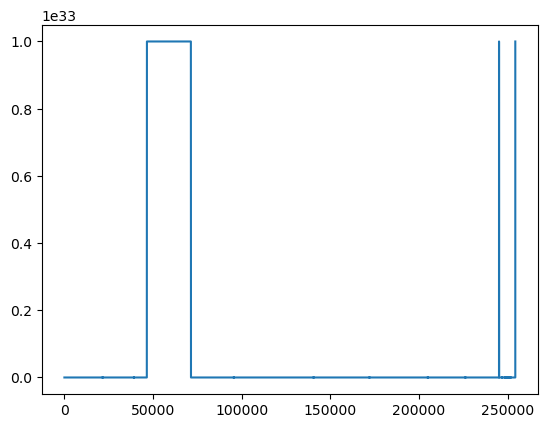

In [133]:
speed = forAS_ds['WSPD'].to_numpy()
speed = make1Dfrom2D(speed)
plt.plot(speed)

In [131]:
shape = speed.shape
np.argmin(shape)

1

In [82]:
winds_ds

<xarray.Dataset>
Dimensions:    (HEIGHT: 1, LATITUDE: 1, LONGITUDE: 1, TIME: 254229, TESTDIM: 1,
                dimName: 1)
Coordinates:
  * HEIGHT     (HEIGHT) float32 4.0
  * LATITUDE   (LATITUDE) float32 0.0
  * LONGITUDE  (LONGITUDE) float32 -140.0
  * TIME       (TIME) datetime64[ns] 2007-01-01 ... 2014-11-18T23:00:00
  * dimName    (dimName) int64 20
  * TESTDIM    (TESTDIM) int64 20
Data variables:
    UWND       (TESTDIM, dimName, TIME, HEIGHT) float32 -7.08 -7.11 ... 1e+33
    VWND       (TESTDIM, dimName, TIME, HEIGHT) float32 3.4 3.2 ... 0.84 1e+33
    WDIR       (TESTDIM, dimName, TIME, HEIGHT) float32 295.6 294.2 ... 1e+33
    WDIR_DM    (TESTDIM, dimName, TIME, HEIGHT) |S1 b'D' b'D' b'D' ... b'D' b'D'
    WDIR_QC    (TESTDIM, dimName, TIME, HEIGHT) float32 2.0 2.0 2.0 ... 1.0 4.0
    WSPD       (TESTDIM, dimName, TIME, HEIGHT) float32 7.85 7.8 ... 4.85 1e+33
    WSPD_DM    (TESTDIM, dimName, TIME, HEIGHT) |S1 b'D' b'D' b'D' ... b'D' b'D'
    WSPD_QC    (TESTDIM, dimName, TIME, HEIGHT) float32 2.0 2.0 2.0 ... 1.0 4.0
Attributes: (12/46)
    time_coverage_start:           2014-09-16T03:50:00Z
    time_coverage_end:             2014-11-18T23:00:00Z
    featureType:                   timeSeries
    format_version:                1.3
    platform_code:                 T0N140W
    platform_type:                 TAO Refresh
    ...                            ...
    publisher_email:               webmaster.ndbc@noaa.gov
    date_created:                  2019-03-08T15:03:44Z
    date_modified:                 2019-03-08T15:03:44Z
    processing_level:              Data manually reviewed
    history:                       Thu Feb  1 17:11:55 2024: ncks -O --mk_rec...
    NCO:                           netCDF Operators version 5.1.7 (Homepage =...

In [90]:
test_ds = add_dimension(winds_ds, "TESTDIM", 20)
test_ds

not adding


<xarray.Dataset>
Dimensions:    (HEIGHT: 1, LATITUDE: 1, LONGITUDE: 1, TIME: 254229, TESTDIM: 1,
                dimName: 1)
Coordinates:
  * HEIGHT     (HEIGHT) float32 4.0
  * LATITUDE   (LATITUDE) float32 0.0
  * LONGITUDE  (LONGITUDE) float32 -140.0
  * TIME       (TIME) datetime64[ns] 2007-01-01 ... 2014-11-18T23:00:00
  * dimName    (dimName) int64 20
  * TESTDIM    (TESTDIM) int64 20
Data variables:
    UWND       (TESTDIM, dimName, TIME, HEIGHT) float32 -7.08 -7.11 ... 1e+33
    VWND       (TESTDIM, dimName, TIME, HEIGHT) float32 3.4 3.2 ... 0.84 1e+33
    WDIR       (TESTDIM, dimName, TIME, HEIGHT) float32 295.6 294.2 ... 1e+33
    WDIR_DM    (TESTDIM, dimName, TIME, HEIGHT) |S1 b'D' b'D' b'D' ... b'D' b'D'
    WDIR_QC    (TESTDIM, dimName, TIME, HEIGHT) float32 2.0 2.0 2.0 ... 1.0 4.0
    WSPD       (TESTDIM, dimName, TIME, HEIGHT) float32 7.85 7.8 ... 4.85 1e+33
    WSPD_DM    (TESTDIM, dimName, TIME, HEIGHT) |S1 b'D' b'D' b'D' ... b'D' b'D'
    WSPD_QC    (TESTDIM, dimName, TIME, HEIGHT) float32 2.0 2.0 2.0 ... 1.0 4.0
Attributes: (12/46)
    time_coverage_start:           2014-09-16T03:50:00Z
    time_coverage_end:             2014-11-18T23:00:00Z
    featureType:                   timeSeries
    format_version:                1.3
    platform_code:                 T0N140W
    platform_type:                 TAO Refresh
    ...                            ...
    publisher_email:               webmaster.ndbc@noaa.gov
    date_created:                  2019-03-08T15:03:44Z
    date_modified:                 2019-03-08T15:03:44Z
    processing_level:              Data manually reviewed
    history:                       Thu Feb  1 17:11:55 2024: ncks -O --mk_rec...
    NCO:                           netCDF Operators version 5.1.7 (Homepage =...

In [112]:
winds_ds.drop_dims('dimName')

<xarray.Dataset>
Dimensions:    (HEIGHT: 1, LATITUDE: 1, LONGITUDE: 1, TIME: 254229, TESTDIM: 1)
Coordinates:
  * HEIGHT     (HEIGHT) float32 4.0
  * LATITUDE   (LATITUDE) float32 0.0
  * LONGITUDE  (LONGITUDE) float32 -140.0
  * TIME       (TIME) datetime64[ns] 2007-01-01 ... 2014-11-18T23:00:00
  * TESTDIM    (TESTDIM) int64 20
Data variables:
    *empty*
Attributes: (12/46)
    time_coverage_start:           2014-09-16T03:50:00Z
    time_coverage_end:             2014-11-18T23:00:00Z
    featureType:                   timeSeries
    format_version:                1.3
    platform_code:                 T0N140W
    platform_type:                 TAO Refresh
    ...                            ...
    publisher_email:               webmaster.ndbc@noaa.gov
    date_created:                  2019-03-08T15:03:44Z
    date_modified:                 2019-03-08T15:03:44Z
    processing_level:              Data manually reviewed
    history:                       Thu Feb  1 17:11:55 2024: ncks -O --mk_rec...
    NCO:                           netCDF Operators version 5.1.7 (Homepage =...

In [113]:
winds_ds

<xarray.Dataset>
Dimensions:    (HEIGHT: 1, LATITUDE: 1, LONGITUDE: 1, TIME: 254229, TESTDIM: 1,
                dimName: 1)
Coordinates:
  * HEIGHT     (HEIGHT) float32 4.0
  * LATITUDE   (LATITUDE) float32 0.0
  * LONGITUDE  (LONGITUDE) float32 -140.0
  * TIME       (TIME) datetime64[ns] 2007-01-01 ... 2014-11-18T23:00:00
  * dimName    (dimName) int64 20
  * TESTDIM    (TESTDIM) int64 20
Data variables:
    UWND       (TESTDIM, dimName, TIME, HEIGHT) float32 -7.08 -7.11 ... 1e+33
    VWND       (TESTDIM, dimName, TIME, HEIGHT) float32 3.4 3.2 ... 0.84 1e+33
    WDIR       (TESTDIM, dimName, TIME, HEIGHT) float32 295.6 294.2 ... 1e+33
    WDIR_DM    (TESTDIM, dimName, TIME, HEIGHT) |S1 b'D' b'D' b'D' ... b'D' b'D'
    WDIR_QC    (TESTDIM, dimName, TIME, HEIGHT) float32 2.0 2.0 2.0 ... 1.0 4.0
    WSPD       (TESTDIM, dimName, TIME, HEIGHT) float32 7.85 7.8 ... 4.85 1e+33
    WSPD_DM    (TESTDIM, dimName, TIME, HEIGHT) |S1 b'D' b'D' b'D' ... b'D' b'D'
    WSPD_QC    (TESTDIM, dimName, TIME, HEIGHT) float32 2.0 2.0 2.0 ... 1.0 4.0
Attributes: (12/46)
    time_coverage_start:           2014-09-16T03:50:00Z
    time_coverage_end:             2014-11-18T23:00:00Z
    featureType:                   timeSeries
    format_version:                1.3
    platform_code:                 T0N140W
    platform_type:                 TAO Refresh
    ...                            ...
    publisher_email:               webmaster.ndbc@noaa.gov
    date_created:                  2019-03-08T15:03:44Z
    date_modified:                 2019-03-08T15:03:44Z
    processing_level:              Data manually reviewed
    history:                       Thu Feb  1 17:11:55 2024: ncks -O --mk_rec...
    NCO:                           netCDF Operators version 5.1.7 (Homepage =...

In [88]:
not 'TESTDIM' in winds_ds.dims

False

In [72]:
arr = test_ds['UWND'].to_numpy()

In [74]:
arr.shape

(1, 254229, 1)

In [8]:
arr = winds_ds['TIME'].to_numpy()

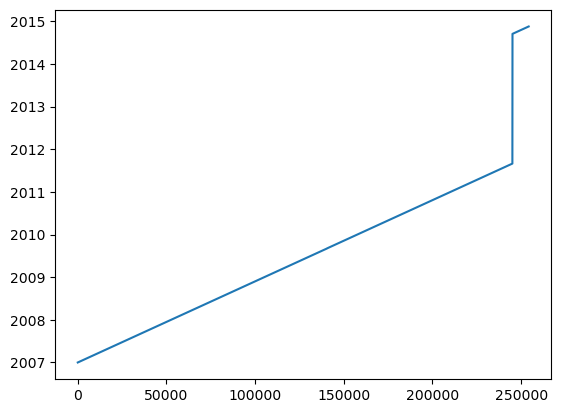

In [9]:
plt.plot(arr)

In [91]:
xds = xr.open_dataset(f'../../downloads/Buoy/extractedGZ2/WINDS/T_{lat:02d}{latUnits.upper()}_{lon:03d}{lonUnits.upper()}_COARE3p5_2007.nc')

In [92]:
xds

<xarray.Dataset>
Dimensions:        (time: 260458, height: 3, LATITUDE: 1, LONGITUDE: 1, depth: 1)
Coordinates:
  * time           (time) datetime64[ns] 2007-01-01 ... 2014-12-31T23:50:00
  * height         (height) float64 3.0 4.0 10.0
  * LATITUDE       (LATITUDE) float32 0.0
  * LONGITUDE      (LONGITUDE) float32 -140.0
  * depth          (depth) float32 1.0
Data variables: (12/19)
    U10N           (time, height) float64 ...
    U10            (time, height) float64 ...
    uwnd           (time, height) float32 ...
    vwnd           (time, height) float32 ...
    U10_direction  (time, height) float32 ...
    WDIR_DM        (time, height) |S1 ...
    ...             ...
    SST            (time, depth) float32 ...
    SST_DM         (time, depth) |S1 ...
    SST_QC         (time, depth) float32 ...
    RH             (time, height) float32 ...
    RELH_DM        (time, height) |S1 ...
    RELH_QC        (time, height) float32 ...

In [93]:
rh = forAS_ds['RELH'].sel(HEIGHT=3).to_numpy()
airt = forAS_ds['AIRT'].sel(HEIGHT=3).to_numpy()
sst = forAS_ds['SST'].sel(DEPTH=1).to_numpy()
speed = forAS_ds['WSPD'].sel(HEIGHT=4).to_numpy()

In [94]:
speed

array([7.85, 7.8 , 7.62, ...,  nan,  nan,  nan], dtype=float32)

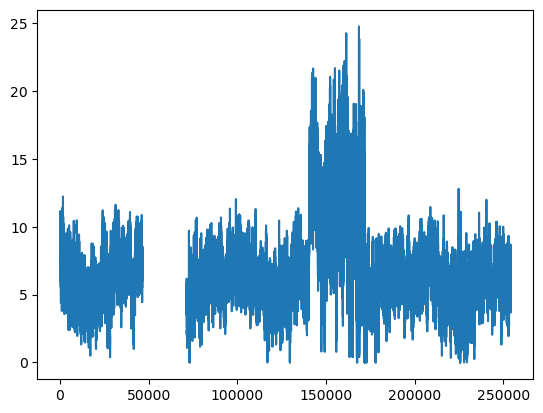

In [95]:
plt.plot(speed)

In [96]:
list(xds.data_vars.keys())

['U10N',
 'U10',
 'uwnd',
 'vwnd',
 'U10_direction',
 'WDIR_DM',
 'WDIR_QC',
 'wspd',
 'WSPD_DM',
 'WSPD_QC',
 'AIRT',
 'AIRT_DM',
 'AIRT_QC',
 'SST',
 'SST_DM',
 'SST_QC',
 'RH',
 'RELH_DM',
 'RELH_QC']

In [134]:
buoyDS = Dataset(f'../../downloads/Buoy/extractedGZ2/WINDS/T_{lat:02d}{latUnits.upper()}_{lon:03d}{lonUnits.upper()}_COARE3p5_2007.nc')

In [137]:
buoyWspd = np.array(buoyDS.variables['U10N'][:,2])
buoyTime = np.array(buoyDS.variables['time'])
buoyTimeUnits = buoyDS.variables['time'].units
cftimes = num2date(buoyTime, buoyTimeUnits)
buoyDateTime = np.array([datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute, dtm.second) for dtm in cftimes])
buoyWdir = np.array(buoyDS.variables['U10_direction'])

buoySST = np.array(buoyDS.variables['SST'])
buoyRH = np.array(buoyDS.variables['RH'])
buoyAIRT = np.array(buoyDS.variables['AIRT'])

nData = len(buoyDateTime)

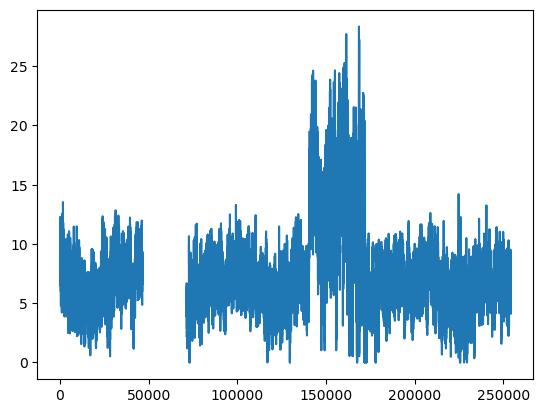

In [138]:
plt.plot(buoyWspd)

In [104]:
buoySST.shape

(260458, 1)